# Perkeso Data Exploration

### Imports

In [95]:
# Imports
random_seed = 42
import os
import pandas as pd
import numpy as np
import glob
#np.random.seed(seed = seed) 
#import random
#random.seed = seed
#import os
#os.environ['PYTHONHASHSEED'] = '0'
#from utils.utilities import *
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('ggplot')
#from scipy import stats
import tensorflow as tf
from scipy import stats
from datetime import datetime

import augment
import preprocess

In [8]:
#to know how many times we need to generate augmented data for each gesture
def aug_times(mov):
    a = {'0': 4, '1': 5,'2': 1, '3': 2, '4': 5, '5': 5, '6': 5, '7': 7, '8': 7}
    return a[mov]

## Load data
patientid_date_label_repetitionNumber_correction_position.txt

In [9]:
def load_move_data(mov):
    # patientid_date_label_repetitionNumber_correction_position.txt
    #moves = ['0']#,'1','2','3','4','5','6','7','8']
    labels = ['1','2']
    subjects = ['104', '209', '205', '213', '303', '204', '201', '210', '211', '206', '103', '203', '305', '202', '217', '105',
     '107',  '304', '302', '212', '102', '306', '208', '214', '307', '106', '216', '215', '218', '207', '301', '101']
    #dates = ['19', '14', '12', '13', '07', '18']
    #position = ['sit', 'stand','chair','wheelchair','Stand-frame']
    data = pd.DataFrame()
    #for mov in moves:
    #print('Move: ',mov)
    for label in labels:
        #count = 0
        #print('Label: ',label)
        for subj in subjects:
            #print('Subj: ',subj)
            for file_name in glob.glob('/home/noureddin/Perkeso-Simplified/'+subj+'_*_'+mov+'_*_'+label+'_*.txt'):
                #count += 1
                tmp_df = pd.read_csv(file_name,header=None)
                if len(tmp_df) >= 28:
                    tmp_ = pd.DataFrame()#for augmentation
                    if label == '2':
                        #now augment data                        
                        augment_times = aug_times(mov)
                        for i in range(0,augment_times):                
                            tdata = tmp_df.values
                            #dd = DA_TimeWarp(DA_Permutation(DA_Rotation(data)))
                            dd = augment.DA_TimeWarp3(augment.DA_Rotation((tdata)))
                            #make sure the # of rows is 28
                            dd = preprocess.normalize_move(pd.DataFrame(dd), 28, mean=False)
                            #transform values into specific range
                            dd = preprocess.normalize_df(dd) # e.g. all cols in range [0,1]
                            #mean centre the df
                            dd = preprocess.mean_centre_data(dd)                
                            tmp_ = tmp_.append(dd,ignore_index=True)
                
                    #make sure the # of rows is 28
                    tmp_df = preprocess.normalize_move(tmp_df, 28, mean=False)
                    #transform values into specific range
                    tmp_df = preprocess.normalize_df(tmp_df) # e.g. all cols in range [0,1] 
                    #mean centre the df
                    tmp_df = preprocess.mean_centre_data(tmp_df)
                    tmp_df['Original'] = 1 
                    if len(tmp_) > 0:
                        tmp_['Original']   = 0
                        tmp_df = tmp_df.append(tmp_,ignore_index=True)
                
                    tmp_df.columns = ['f_'+str(i) for i in range(tmp_df.shape[1])]
                    tmp_df.rename(columns={'f_75':'Original'}, inplace=True)
                    
                    tmp_df['Subject'] = subj
                    tmp_df['Class'] = 1 if label == '1' else 0
                    data = data.append(tmp_df,ignore_index=True)
                    #print(data.shape)   
    return data

In [10]:
#data = load_move_data('6')

In [11]:
#print(data[data['Class'] == 1].shape)
#print(data[data['Class'] == 0].shape)
#data.tail()

### Hyperparameters

In [12]:
input_width = 28
batch_size = 8      # Batch size
seq_len = input_width          # Number of steps
learning_rate = 0.0001
epochs = 30
n_classes = 2
n_channels = 75
num_features = n_channels
#actif = tf.nn.tanh ## ok
#actif = tf.nn.relu ## ok
actif = tf.nn.leaky_relu ## good
#actif = tf.sigmoid ## bad

#init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=False) ## ok
#init = tf.random_normal_initializer() ## bad
init = tf.glorot_uniform_initializer() ## good
#init = tf.glorot_normal_initializer() ## ok

### Construct the graph
* Placeholders
* Build Convolutional Layers (Note: Should we use a different activation? Like tf.nn.tanh?)
* Then flatten and pass to the classifier

In [13]:
def create_graph_down():
    tf.reset_default_graph()
    graph = tf.Graph()
    tf.set_random_seed(random_seed)
    # Construct placeholders
    with graph.as_default(), tf.device('/gpu:0'):
        tf.set_random_seed(random_seed)
        inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
        labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
        keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
        learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')
        
        # (batch, 28, 75) --> (batch, 14, 512)
        conv1 = tf.layers.conv1d(inputs=inputs_, filters=512, kernel_size=3, strides=1, 
                                 padding='same', activation = actif, kernel_initializer=init)
        max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')

        # (batch, 14, 132) --> (batch, 7, 256)
        conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=256, kernel_size=5, strides=1, 
                                 padding='same', activation = actif, kernel_initializer=init)
        max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')

        # (batch, 7, 64) --> (batch, 7, 128)
        conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=7, strides=1, 
                                 padding='same', activation = actif, kernel_initializer=init)
    
        flat = tf.reshape(conv3, (-1, 7*128))
        dense1 = tf.layers.dense(inputs=flat,   units=256, activation = actif)
        dense2 = tf.layers.dense(inputs=dense1, units=128, activation = actif)
        dense3 = tf.layers.dense(inputs=dense2, units=64,  activation = actif)
        dense4 = tf.layers.dense(inputs=dense3, units=32,  activation = actif)
        dense5 = tf.layers.dense(inputs=dense4, units=16,  activation = actif)
        dense6 = tf.layers.dense(inputs=dense5, units= 8,  activation = actif)

        dropout = tf.nn.dropout(dense6, keep_prob=keep_prob_, seed = random_seed)

        # Predictions
        logits = tf.layers.dense(dropout, n_classes)
    
        # Cost function and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,
            labels=labels_))
        optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
 
        # Accuracy
        correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
        return (graph, cost, optimizer,logits, accuracy, inputs_ , labels_ , keep_prob_, learning_rate_)

In [14]:
def process_move(mov):
    results = []
    appended_data = load_move_data(mov)
    print("Move:", mov, "Data size:", appended_data.shape)
    subjects = list(appended_data['Subject'].unique())
    #subjects   = ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10']
    #start_timex = datetime.now()
    
    for test_subj in subjects:
        print('Doing subj:', test_subj)
        subj_start_time = datetime.now()
        ### Split data into Train and Test
        #test_subj           = 's06'
        test_subject        = appended_data[appended_data['Subject'] == test_subj]
        # test only on original data .. don't include augment data
        test_subject = test_subject[test_subject['Original'] == 1]

        train_subjects         = appended_data[appended_data['Subject'] != test_subj]
        #train_subjects = train_subjects[train_subjects['Class'] == 0]

        X_train, labels_train  = preprocess.segment_signal(train_subjects, input_width, num_features)
        X_test, labels_test    = preprocess.segment_signal(test_subject, input_width, num_features)

        # Normalize?
        #X_train, mean_   = zero_mean(X_train,0) 
        ##X_train, mean_, std_    = standardize(X_train,0,0)
        # replace NaNs with 0's
        X_train[np.isnan(X_train)] = 0

        # Normalize?
        #X_test, _        = zero_mean(X_test,mean_, train=False)
        ##X_test, _, _            = standardize(X_test,mean_, std_, train=False)
        # replace NaNs with 0's
        X_test[np.isnan(X_test)] = 0



        #X_train, mean, std    = normalize(X_train)
        #X_test                = normalize(X_test)

        #### One-hot encoding for labels:
        # Notice that we add two extra elements 0,1
        # Because sometimes we only have correct or incorrect
        # move for some subjects and this makes one hot encoding not possible
        # one_hot and then drop the elements we added        
        y_tr   = preprocess.one_hot(np.append(labels_train, [0,1]))[:-2]
        y_test = preprocess.one_hot(np.append(labels_test, [0,1]))[:-2]
        #print('Doing', test_subj)
        #we make sure there's at least 1 test episode for this test subject
        #otherwise no point training the CNN
        if len(y_test) > 0:
            graph, cost, optimizer, logits, accuracy, inputs_ , labels_ , keep_prob_, learning_rate_ = create_graph_down()
            #with graph.as_default():
            #    saver = tf.train.Saver()    
            with tf.Session(graph=graph) as sess:
                saver = tf.train.Saver()    
                tf.set_random_seed(random_seed)
                sess.run(tf.global_variables_initializer())
                # Loop over epochs
                for e in range(epochs):
                    # Loop over batches
                    #for x,y in get_random_batches(X_train, y_tr, num_batches = 125, batch_size = 125):
                    for x,y in preprocess.get_batches(X_train, y_tr, batch_size, shuffle=True):            
                        # Feed dictionary
                        feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}

                        # Loss
                        loss, _ ,logits_, acc = sess.run([cost, optimizer, logits, accuracy], feed_dict = feed) 
                        #print('Predicted:',tf.argmax(logits_, 1).eval())
                        #print('Actual:',tf.argmax(y, 1).eval())
                        #print(acc)
                        #print('----')

                        # Print at each 5 epochs
                        #if (e % 50 == 0):
                        #    print("Epoch: {}/{}".format(e, epochs),
                        #          "Train loss: {:6f}".format(loss),
                        #          "Train acc: {:.6f}".format(acc))

                # training has finished .. now predict the test set
                test_acc = []
                print(X_test.shape, y_test.shape)
                for x_t, y_t in preprocess.get_batches(X_test, y_test, batch_size=10, shuffle=True):
                    #    #print(x_t)
                    feed = {inputs_: x_t,
                            labels_: y_t,
                            keep_prob_: 1}
                        #print(x_t.shape)

                    batch_acc, b_logits = sess.run([accuracy,logits], feed_dict=feed)
                    #print('Predicted:',tf.argmax(b_logits, 1).eval())
                    #print('Actual:',tf.argmax(y_t, 1).eval())
                    #print(batch_acc)
                    #print('----')
                    test_acc.append(batch_acc)

                results.append(np.mean(test_acc))
                    #print("Move: "+mov+" .. done testing on Subj:" + test_subj)
                    #print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
                    #print("Time taken: ", datetime.now() - start_time)
                    #print("===============================================")
        print("Subj:", test_subj,"took: ", datetime.now() - subj_start_time)
    return results  
        

In [15]:
#r = process_move('0')

In [16]:
moves = ['0','1','2','3','4','5','6','7','8']
results_dict = {}
for mov in moves:
    start_time  = datetime.now()
    mov_results = process_move(mov)
    results_dict[mov] = mov_results
    print("Overall accuracy: {:.6f}".format(np.mean(results_dict[mov])))
    print("Time taken: ", datetime.now() - start_time)
    print("===============================================")

Move: 0 Data size: (11900, 78)
Doing subj: 104
(6, 28, 75) (6, 2)
Subj: 104 took:  0:00:09.408696
Doing subj: 209
(7, 28, 75) (7, 2)
Subj: 209 took:  0:00:08.315073
Doing subj: 205
(2, 28, 75) (2, 2)
Subj: 205 took:  0:00:08.509293
Doing subj: 213
(6, 28, 75) (6, 2)
Subj: 213 took:  0:00:08.440477
Doing subj: 303
(12, 28, 75) (12, 2)
Subj: 303 took:  0:00:11.081040
Doing subj: 204
(7, 28, 75) (7, 2)
Subj: 204 took:  0:00:08.386379
Doing subj: 201
(13, 28, 75) (13, 2)
Subj: 201 took:  0:00:09.853670
Doing subj: 206
(11, 28, 75) (11, 2)
Subj: 206 took:  0:00:08.564911
Doing subj: 103
(24, 28, 75) (24, 2)
Subj: 103 took:  0:00:08.316638
Doing subj: 305
(10, 28, 75) (10, 2)
Subj: 305 took:  0:00:08.646218
Doing subj: 217
(8, 28, 75) (8, 2)
Subj: 217 took:  0:00:08.317584
Doing subj: 105
(11, 28, 75) (11, 2)
Subj: 105 took:  0:00:08.384270
Doing subj: 304
(6, 28, 75) (6, 2)
Subj: 304 took:  0:00:08.667765
Doing subj: 302
(12, 28, 75) (12, 2)
Subj: 302 took:  0:00:08.359027
Doing subj: 212
(

(6, 28, 75) (6, 2)
Subj: 217 took:  0:00:09.689421
Doing subj: 105
(12, 28, 75) (12, 2)
Subj: 105 took:  0:00:09.837023
Doing subj: 304
(7, 28, 75) (7, 2)
Subj: 304 took:  0:00:09.894053
Doing subj: 302
(12, 28, 75) (12, 2)
Subj: 302 took:  0:00:09.644537
Doing subj: 212
(6, 28, 75) (6, 2)
Subj: 212 took:  0:00:09.839561
Doing subj: 102
(25, 28, 75) (25, 2)
Subj: 102 took:  0:00:09.419905
Doing subj: 306
(12, 28, 75) (12, 2)
Subj: 306 took:  0:00:09.857192
Doing subj: 214
(5, 28, 75) (5, 2)
Subj: 214 took:  0:00:09.850059
Doing subj: 307
(13, 28, 75) (13, 2)
Subj: 307 took:  0:00:09.653646
Doing subj: 215
(10, 28, 75) (10, 2)
Subj: 215 took:  0:00:09.313848
Doing subj: 301
(12, 28, 75) (12, 2)
Subj: 301 took:  0:00:09.920963
Doing subj: 101
(12, 28, 75) (12, 2)
Subj: 101 took:  0:00:09.561091
Doing subj: 201
(7, 28, 75) (7, 2)
Subj: 201 took:  0:00:08.972299
Doing subj: 211
(5, 28, 75) (5, 2)
Subj: 211 took:  0:00:09.267808
Doing subj: 216
(7, 28, 75) (7, 2)
Subj: 216 took:  0:00:08.98

(6, 28, 75) (6, 2)
Subj: 212 took:  0:00:08.943458
Overall accuracy: 0.841220
Time taken:  0:04:12.685287


In [17]:
results_dict

{'0': [1.0,
  0.85714287,
  1.0,
  1.0,
  1.0,
  0.85714287,
  0.8,
  1.0,
  1.0,
  1.0,
  0.875,
  1.0,
  1.0,
  0.9,
  0.8333333,
  0.95,
  0.8,
  0.71428573,
  0.9,
  1.0,
  1.0,
  1.0,
  0.8,
  0.8333333,
  0.85],
 '1': [0.85714287,
  0.8333333,
  0.6,
  0.5,
  1.0,
  0.6666667,
  0.7,
  0.8333333,
  1.0,
  0.6,
  1.0,
  0.8,
  0.5714286,
  0.8,
  0.5,
  0.9,
  0.8333333,
  1.0,
  0.8,
  0.5,
  0.9,
  1.0,
  0.3,
  1.0,
  0.8,
  0.0],
 '2': [1.0,
  1.0,
  0.8333333,
  1.0,
  0.82,
  0.9,
  0.6,
  1.0,
  1.0,
  0.9,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.6666667,
  0.95,
  1.0,
  0.5,
  0.9,
  0.8,
  0.9,
  1.0,
  0.4,
  0.6],
 '3': [1.0,
  1.0,
  1.0,
  0.85999995,
  0.9,
  0.6,
  1.0,
  1.0,
  0.75,
  0.8333333,
  1.0,
  1.0,
  1.0,
  1.0,
  0.6666667,
  1.0,
  1.0,
  0.4,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.85714287,
  0.9,
  1.0,
  0.9],
 '4': [0.6666667,
  1.0,
  1.0,
  0.42857143,
  1.0,
  0.4,
  0.95,
  1.0,
  0.4333333,
  0.8333333,
  1.0,
  0.85714287,
  1.0,
  0.5,
  0.

In [52]:
np.mean(results_dict['3'])

TypeError: string indices must be integers

In [56]:
results_dict = {'0': [1.0, 0.85714287, 1.0, 1.0, 1.0, 0.85714287, 0.8, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 0.9, 0.8333333, 0.95, 0.8, 0.71428573, 0.9, 1.0, 1.0, 1.0, 0.8, 0.8333333, 0.85], '1': [0.85714287, 0.8333333, 0.6, 0.5, 1.0, 0.6666667, 0.7, 0.8333333, 1.0, 0.6, 1.0, 0.8, 0.5714286, 0.8, 0.5, 0.9, 0.8333333, 1.0, 0.8, 0.5, 0.9, 1.0, 0.3, 1.0, 0.8, 0.0], '2': [1.0, 1.0, 0.8333333, 1.0, 0.82, 0.9, 0.6, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666667, 0.95, 1.0, 0.5, 0.9, 0.8, 0.9, 1.0, 0.4, 0.6], '3': [1.0, 1.0, 1.0, 0.85999995, 0.9, 0.6, 1.0, 1.0, 0.75, 0.8333333, 1.0, 1.0, 1.0, 1.0, 0.6666667, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85714287, 0.9, 1.0, 0.9], '4': [0.6666667, 1.0, 1.0, 0.42857143, 1.0, 0.4, 0.95, 1.0, 0.4333333, 0.8333333, 1.0, 0.85714287, 1.0, 0.5, 0.95, 1.0, 1.0, 1.0, 0.6, 0.9, 0.9, 1.0, 0.4, 0.85714287], '5': [1.0, 1.0, 0.0, 0.6666667, 0.9, 0.5714286, 0.8333333, 1.0, 0.95, 0.8, 1.0, 1.0, 0.9, 1.0, 0.9, 0.6666667, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75], '6': [1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.7, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.2, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888889, 0.8, 1.0, 1.0, 0.0, 0.65], '7': [1.0, 1.0, 0.9, 1.0, 0.5714286, 0.85, 1.0, 1.0, 0.79999995, 0.85714287, 1.0, 0.8333333, 0.9, 0.95, 1.0, 0.8333333, 1.0, 0.5, 1.0, 0.11111111, 1.0, 1.0, 0.5, 0.2], '8': [1.0, 0.75, 0.33333334, 1.0, 0.9, 0.8333333, 0.6, 1.0, 0.9, 0.775, 0.8333333, 1.0, 1.0, 0.7, 0.95, 1.0, 0.42857143, 1.0, 1.0, 0.9, 0.2857143, 1.0, 1.0, 1.0]}

In [23]:
import json
with open('NIPS19-Perkeso-CNN-Results.json', 'w') as outfile:
    json.dump(str(results_dict), outfile)

In [54]:
import json

with open('NIPS19-Perkeso-CNN-Results.json') as json_file:  
    results_dict = json.loads(json_file.read())

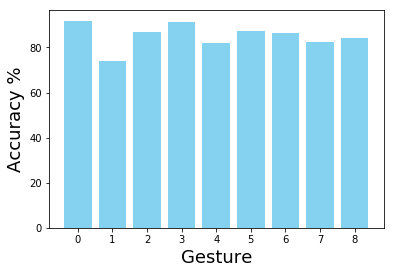

In [69]:
D = {}
for key, value in results_dict.items():
    D[key] = (np.mean(value)*100)


# Create bars
barWidth = 1
bars1 = list(D.values())

# The X position of bars
r1 = range(len(D))

plt.bar(r1, bars1, align='center', color = (0.2,0.7,0.9,0.6))

plt.xticks(range(len(D)), list(D.keys()))


plt.xlabel('Gesture',  fontsize=18)
plt.ylabel('Accuracy %', fontsize=18)
plt.show()

In [103]:
np.mean(list(D.values()))

85.24172980017569

In [102]:
D

{'0': 91.88095228,
 '1': 74.21245411538462,
 '2': 87.08000000000001,
 '3': 91.35978822222222,
 '4': 81.98412695833332,
 '5': 87.45421269230769,
 '6': 86.55555559999999,
 '7': 82.52645470833335,
 '8': 84.122023625}

In [76]:
print(min(results_dict['0']), max(results_dict['0']))

0.71428573 1.0


In [77]:
[1, 2, 3, 4, 1, 4, 1].count(1)

3

In [91]:
results_dict['6'].count(1)

17

In [94]:
moves = ['0','1','2','3','4','5','6','7','8']
for m in moves:
    print(m)
    print(results_dict[m].count(1))
    print(min(results_dict[m]), max(results_dict[m]))
    print('----')
    

0
12
0.71428573 1.0
----
1
6
0.0 1.0
----
2
12
0.4 1.0
----
3
17
0.4 1.0
----
4
10
0.4 1.0
----
5
14
0.0 1.0
----
6
17
0.0 1.0
----
7
11
0.11111111 1.0
----
8
11
0.2857143 1.0
----
